# Component 9: Model Evaluation

Compute comprehensive metrics, confusion matrices, and ROC curves for all models

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc,
    balanced_accuracy_score
)
from sklearn.preprocessing import label_binarize
import json
import os

OUTPUT_DIR = '../outputs/evaluation'
os.makedirs(OUTPUT_DIR, exist_ok=True)

test_df = pd.read_csv('../outputs/test_manifest.csv')
classes = sorted(test_df['class_name'].unique())
print(f'Test set: {len(test_df)} images, {len(classes)} classes')

Test set: 1762 images, 4 classes


In [6]:

# Custom Label Smoothing Loss (Needed for loading models)
@tf.keras.utils.register_keras_serializable()
class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes=4, smoothing=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.smoothing = smoothing
        
    def get_config(self):
        config = super().get_config()
        config.update({'num_classes': self.num_classes, 'smoothing': self.smoothing})
        return config
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, self.num_classes)
        y_true_smooth = y_true_one_hot * (1 - self.smoothing) + self.smoothing / self.num_classes
        return tf.keras.losses.categorical_crossentropy(y_true_smooth, y_pred)


## Build Test Dataset

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img / 255.0, label

test_ds = tf.data.Dataset.from_tensor_slices((
    test_df['filepath'].values,
    test_df['class_label'].values
))
test_ds = test_ds.map(preprocess, tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print('✓ Test dataset created')

✓ Test dataset created


## Evaluate All Models


Evaluating baseline_cnn...
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
  Accuracy: 0.7480
  Balanced Accuracy: 0.5673
  Macro F1: 0.5285


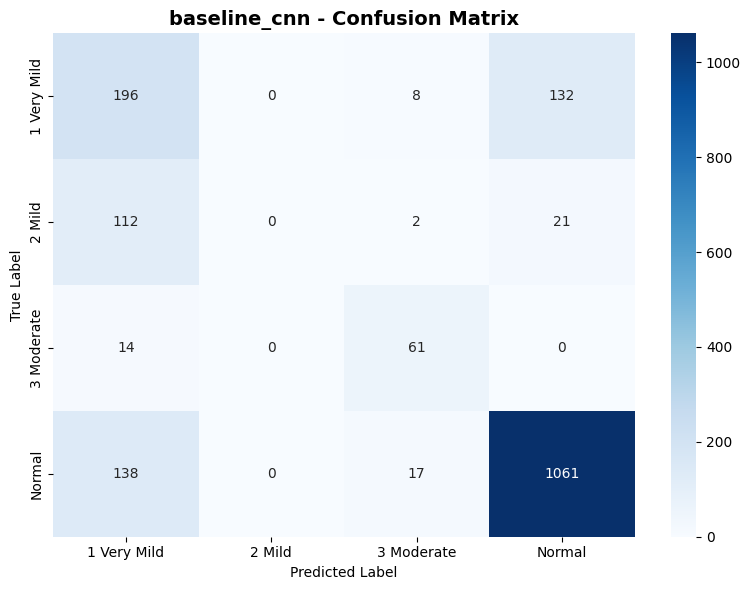

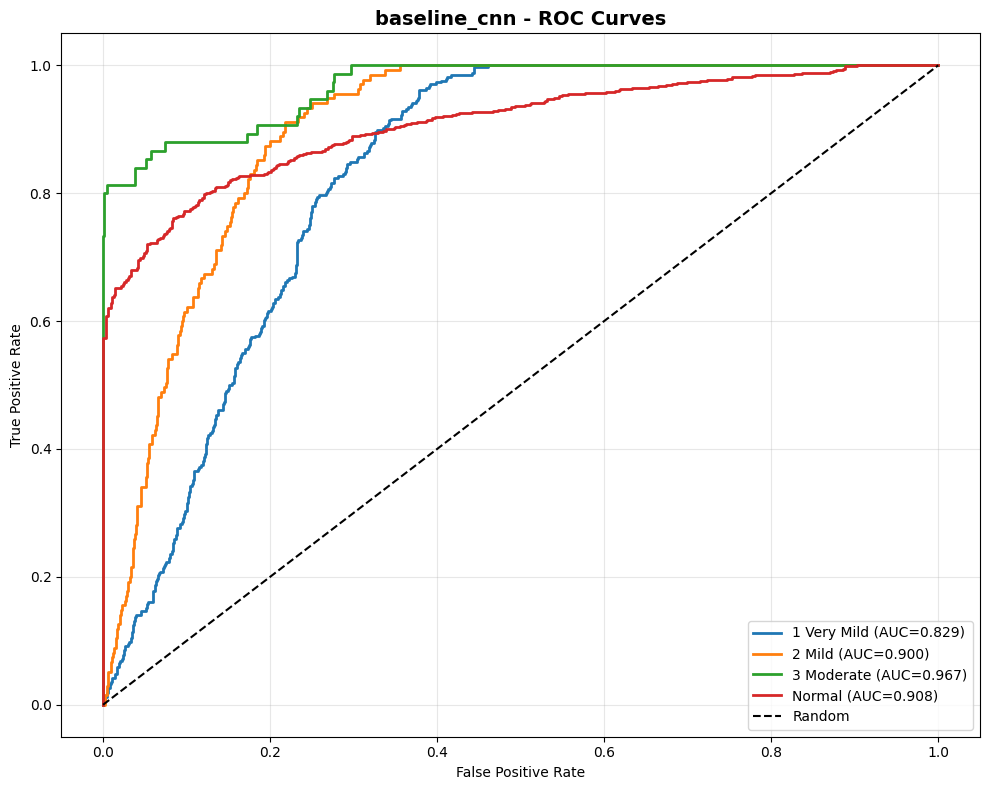


Evaluating resnet50...


: 

: 

: 

In [8]:
models = ['baseline_cnn', 'resnet50', 'resnet50_attention', 'efficientnetb0']
results = []

for model_name in models:
    model_path = f'../outputs/models/{model_name}_best.h5'
    if not os.path.exists(model_path):
        print(f'⚠️  Model not found: {model_path}')
        continue
    
    print(f'\nEvaluating {model_name}...')
    model = tf.keras.models.load_model(model_path, custom_objects={'LabelSmoothingLoss': LabelSmoothingLoss, 'label_smoothing_loss': LabelSmoothingLoss})
    
    # Predictions
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_df['class_label'].values
    
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    
    macro_f1 = np.mean(f1)
    weighted_f1 = np.average(f1, weights=s)
    
    results.append({
        'model': model_name,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    })
    
    print(f'  Accuracy: {acc:.4f}')
    print(f'  Balanced Accuracy: {bal_acc:.4f}')
    print(f'  Macro F1: {macro_f1:.4f}')
    
    # Save predictions
    pred_df = test_df.copy()
    pred_df['predicted_label'] = y_pred
    pred_df['is_correct'] = y_true == y_pred
    for i, cn in enumerate(classes):
        pred_df[f'prob_{cn.replace(" ", "_")}'] = y_pred_probs[:, i]
    pred_df.to_csv(f'{OUTPUT_DIR}/{model_name}_predictions.csv', index=False)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/{model_name}_confusion_matrix.png', dpi=200)
    plt.show()
    
    # ROC curves
    y_bin = label_binarize(y_true, classes=list(range(len(classes))))
    plt.figure(figsize=(10, 8))
    for i, cn in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{cn} (AUC={roc_auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curves', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/{model_name}_roc_curves.png', dpi=200)
    plt.show()

results_df = pd.DataFrame(results).sort_values('macro_f1', ascending=False)
results_df.to_csv(f'{OUTPUT_DIR}/all_models_metrics.csv', index=False)
print('\n' + '='*60)
print('✅ EVALUATION COMPLETE')
print('='*60)
print('\nModel Rankings by Macro F1:')
print(results_df)